### Step 1 匯入需要的套件

In [ ]:
#Third party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import uniform, randint
from scipy.stats.mstats import winsorize
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import os, sys, math
import glob
import warnings
from pandas_profiling import ProfileReport 

from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier

#Global configuration
pd.options.mode.chained_assignment = None
seed = 2020
np.random.seed(seed)

### Step 2 Train_full是已經補好值的檔案

In [ ]:
df_full = pd.read_excel("train_full_V2.xls")
test_full = pd.read_excel("test_full_V2.xls")

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [ ]:
df_full.shape

(5314, 107)

In [ ]:
df_full.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5314 entries, 0 to 5313
Data columns (total 107 columns):
 #    Column                   Dtype  
---   ------                   -----  
 0    VAR1                     int64  
 1    Cumulative_dose_g        float64
 2    Duration                 int64  
 3    PDD                      float64
 4    AGE                      int64  
 5    SEX_TYPE                 int64  
 6    DAY                      float64
 7    BMI                      float64
 8    Aver_dose_kg             float64
 9    rx_ICMs                  int64  
 10   rx_AEDs                  int64  
 11   rx_NSAIDs                int64  
 12   rx_GCs                   int64  
 13   rx_NOACs                 int64  
 14   rx_heparins              int64  
 15   rx_p2y12s                int64  
 16   rx_aspirins              int64  
 17   rx_antithrombotics       int64  
 18   rx_allopurinoLs          int64  
 19   rx_febuxostats           int64  
 20   rx_benzbromarones        int

#### try to drop very low incidence variables 

In [ ]:
df_full.shape

(5314, 107)

In [ ]:
df_full[['TSH_abnor','TSH_trend','TSH_slope', 'TSH_trend_past', 'TSH_slope_past',
        'FT4_abnor', 'FT4_trend', 'FT4_slope','FT4_trend_past', 'FT4_slope_past']] \
= df_full[['TSH_abnor','TSH_trend','TSH_slope', 'TSH_trend_past', 'TSH_slope_past',
        'FT4_abnor', 'FT4_trend', 'FT4_slope','FT4_trend_past', 'FT4_slope_past']].fillna(0)

test_full[['TSH_abnor','TSH_trend','TSH_slope', 'TSH_trend_past', 'TSH_slope_past',
        'FT4_abnor', 'FT4_trend', 'FT4_slope','FT4_trend_past', 'FT4_slope_past']] \
= test_full[['TSH_abnor','TSH_trend','TSH_slope', 'TSH_trend_past', 'TSH_slope_past',
        'FT4_abnor', 'FT4_trend', 'FT4_slope','FT4_trend_past', 'FT4_slope_past']].fillna(0)

### 開始跑Data

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0,min_value=0)
df1_imp = imp.fit_transform(df_full)
imp.fit(df_full)
test1_imp  = imp.transform(test_full)

In [ ]:
df1_imp = pd.DataFrame(df1_imp,columns =df_full.columns)
test1_imp = pd.DataFrame(test1_imp,columns =test_full.columns)

df1_imp.to_csv('df1_imp.csv')
test1_imp.to_csv('test1_imp.csv')

In [ ]:
df1_imp=df1_imp.drop(columns = ['VAR1'])
test1_imp=test1_imp.drop(columns = ['VAR1'])

In [ ]:
X1 = df1_imp.drop(columns = ['case'])
y1 = df1_imp['case']
X1_t = test1_imp.drop(columns = ['case'])
y1_t = test1_imp['case']

In [ ]:
myCatCols_1 = [col for col in X1.columns if all(X1[col].value_counts().index.isin([-1, 0, 1]))]
myContinuousCols_1 = [col for col in X1.columns if not all(X1[col].value_counts().index.isin([-1, 0, 1]))]

from sklearn.preprocessing import RobustScaler
scaler_1 = RobustScaler(quantile_range=(25.0, 75.0)).fit(X1[myContinuousCols_1])
X1[myContinuousCols_1] = scaler_1.transform(X1[myContinuousCols_1])

In [ ]:
myCatCols_1_t = [col for col in X1_t.columns if all(X1_t[col].value_counts().index.isin([-1, 0, 1]))]
myContinuousCols_1_t = [col for col in X1_t.columns if not all(X1_t[col].value_counts().index.isin([-1, 0, 1]))]

from sklearn.preprocessing import RobustScaler
X1_t[myContinuousCols_1_t] = scaler_1.transform(X1_t[myContinuousCols_1_t])

In [ ]:
frames = [X1[myCatCols_1],X1[myContinuousCols_1],y1]

df1_window = pd.concat(frames,axis=1)

frames = [X1_t[myCatCols_1_t],X1_t[myContinuousCols_1_t],y1_t]

test1_window = pd.concat(frames,axis=1)

In [ ]:
#Split the predictors and target
X1 = df1_window.drop('case', axis=1)
y1 = df1_window.case
#Split the predictors and target
X1_t = test1_window.drop('case', axis=1)
y1_t = test1_window.case

In [ ]:
print('原始features',X1.shape)

原始features (5314, 105)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import datasets
from sklearn.model_selection import train_test_split
from imblearn import under_sampling, over_sampling

#Performing random undersampling(1:1)
rus = under_sampling.RandomUnderSampler(sampling_strategy=1.0,random_state=0)
X1_rus, y1_rus = rus.fit_resample(X1, y1)
# Split dataset into training set and test set
X_train, X_test, y_train, y_test =\
train_test_split(X1_rus,y1_rus, random_state=2021, test_size=0.2,stratify=y1_rus)


from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
feature_imp = pd.Series(clf.feature_importances_,index=X1_rus.columns.values).sort_values(ascending=False)
feature_imp.to_csv('feature_imp.csv')

Accuracy: 0.8118081180811808
Recall: 0.7333333333333333


In [ ]:
def model_eval_new(clf, X_test=X1_t, y_test=y1_t):
    y_pred = clf.predict(X_test)
    print("Mean cross-validated Recall of the best_estimator: {0:.3f}".format(clf.best_score_))
    print("Recall on test data: {0:.3f}".format(clf.score(X1_t, y1_t)))
    print(metrics.classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(clf.best_params_))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred)
    metrics.plot_roc_curve(clf, X_test, y_test)
    plt.show()

#### 試試看其他SMOTE或是ENN等IMBLANCE處理方法

In [ ]:
#Split the predictors and target
X1 = df1_window.drop('case', axis=1)
y1 = df1_window.case
#Split the predictors and target
X1_t = test1_window.drop('case', axis=1)
y1_t = test1_window.case

In [ ]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

cv = StratifiedKFold(n_splits=5)
for train_idx, test_idx, in cv.split(X1, y1):
    X_train, y_train = X1.iloc[train_idx], y1.iloc[train_idx]
    X_test, y_test = X1.iloc[test_idx], y1.iloc[test_idx]
    X_train_oversampled, y_train_oversampled = SMOTE().fit_resample(X_train, y_train)

### 終於找出pipeline的code

In [ ]:
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
import scikitplot as skplt
%matplotlib inline
import matplotlib.pyplot as plt

### AdaBoost

#### 1.AdaBoost+oversampling

Optimal number of features : 31


The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.


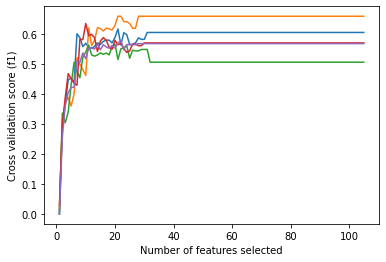

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
ada = AdaBoostClassifier(random_state=1)
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=ada,
    step=1,
    cv=StratifiedKFold(5),
    scoring="f1",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X1, y1)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [ ]:
print(X1.columns[rfecv.support_])

Index(['rx_heparins', 'rx_aspirins', 'dx_renal_dyss', 'Albumin_REMARK',
       'Cumulative_dose_g', 'Duration', 'AGE', 'DAY', 'BMI', 'Aver_dose_kg',
       'charlson_TOT_GRP', 'lab_TSH', 'lab_FT4', 'lab_Prothrom_time',
       'lab_SCr', 'lab_wbc', 'lab_hgb', 'lab_plt', 'lab_Cholesterol',
       'lab_AST', 'lab_ALT', 'lab_HDL', 'lab_LDL', 'TSH_abnor', 'TSH_trend',
       'MIN_TSH', 'MAX_TSH', 'median_TSH', 'MIN_FT4', 'MAX_FT4', 'median_FT4'],
      dtype='object')


In [ ]:
from yellowbrick.model_selection import RFECV
min_features_to_select = 1 
ada = AdaBoostClassifier(random_state=1)
visualizer = RFECV(
    estimator=ada,
    step=1,
    cv=StratifiedKFold(5),
    scoring="f1",
    min_features_to_select=min_features_to_select,
)
visualizer.fit(X1, y1)        # Fit the data to the visualizer
visualizer.show()   

In [ ]:
df_ada_fs=df1_window.filter(['rx_heparins', 'rx_aspirins', 'dx_renal_dyss', 'Albumin_REMARK',
                             'Cumulative_dose_g', 'Duration', 'AGE', 'DAY', 'BMI', 'Aver_dose_kg',
                             'charlson_TOT_GRP', 'lab_TSH', 'lab_FT4', 'lab_Prothrom_time',
                             'lab_SCr', 'lab_wbc', 'lab_hgb', 'lab_plt', 'lab_Cholesterol',
                             'lab_AST', 'lab_ALT', 'lab_HDL', 'lab_LDL', 'TSH_abnor', 'TSH_trend',
                             'MIN_TSH', 'MAX_TSH', 'median_TSH', 'MIN_FT4', 'MAX_FT4', 'median_FT4',"case"])
test_ada_fs=test1_window.filter(['rx_heparins', 'rx_aspirins', 'dx_renal_dyss', 'Albumin_REMARK',
                             'Cumulative_dose_g', 'Duration', 'AGE', 'DAY', 'BMI', 'Aver_dose_kg',
                             'charlson_TOT_GRP', 'lab_TSH', 'lab_FT4', 'lab_Prothrom_time',
                             'lab_SCr', 'lab_wbc', 'lab_hgb', 'lab_plt', 'lab_Cholesterol',
                             'lab_AST', 'lab_ALT', 'lab_HDL', 'lab_LDL', 'TSH_abnor', 'TSH_trend',
                             'MIN_TSH', 'MAX_TSH', 'median_TSH', 'MIN_FT4', 'MAX_FT4', 'median_FT4',"case"])
#Split the predictors and target
X1 = df_ada_fs.drop('case', axis=1)
y1 = df_ada_fs.case
#Split the predictors and target
X1_t = test_ada_fs.drop('case', axis=1)
y1_t = test_ada_fs.case

Fitting 5 folds for each of 16 candidates, totalling 80 fits
training set performance
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       928
         1.0       0.63      0.70      0.66       135

    accuracy                           0.91      1063
   macro avg       0.79      0.82      0.80      1063
weighted avg       0.91      0.91      0.91      1063



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


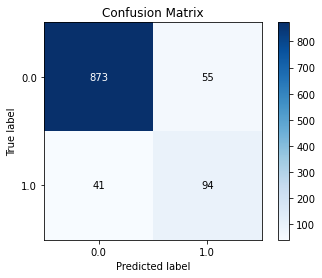

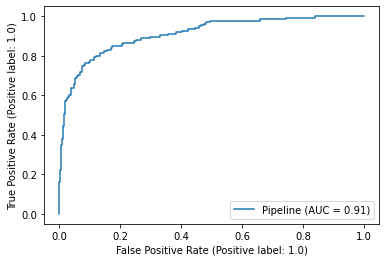

testing set performance
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      1001
         1.0       0.64      0.64      0.64       182

    accuracy                           0.89      1183
   macro avg       0.79      0.79      0.79      1183
weighted avg       0.89      0.89      0.89      1183



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


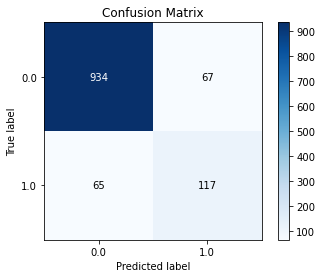

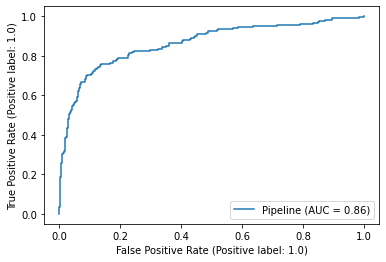

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline, Pipeline
from catboost import Pool, CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold
kfold=KFold(n_splits=5,random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.2,
                                                    stratify=y1,
                                                    random_state=11)
classifier = AdaBoostClassifier(random_state=1)
sampler = RandomOverSampler(sampling_strategy=0.5)

rs_parameters =  {'adaboostclassifier__n_estimators': [10,50,250,1000],               
                  'adaboostclassifier__learning_rate': [0.01,0.1],
                  'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')
              }


smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kfold,
                         scoring='f1',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train,y_train)
bestimator = grid_imba.best_estimator_

# training set performance
print('training set performance')
y_pred1 = bestimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred1))
skplt.metrics.plot_confusion_matrix(y_test, y_pred1)
metrics.plot_roc_curve(bestimator,X_test, y_test)
plt.show()

# testing set performance
print('testing set performance')
y_pred = bestimator.predict(X1_t)
print(metrics.classification_report(y1_t, y_pred))
skplt.metrics.plot_confusion_matrix(y1_t, y_pred)
metrics.plot_roc_curve(bestimator ,X1_t, y1_t)
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
training set performance
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       928
         1.0       0.63      0.72      0.67       135

    accuracy                           0.91      1063
   macro avg       0.79      0.83      0.81      1063
weighted avg       0.92      0.91      0.91      1063



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


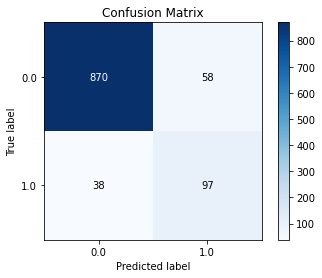

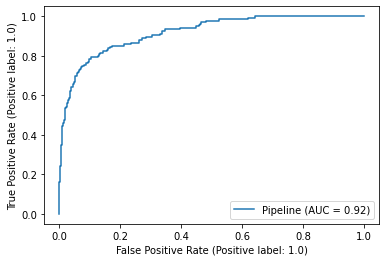

testing set performance
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1001
         1.0       0.65      0.64      0.64       182

    accuracy                           0.89      1183
   macro avg       0.79      0.79      0.79      1183
weighted avg       0.89      0.89      0.89      1183



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


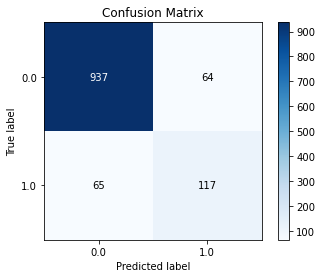

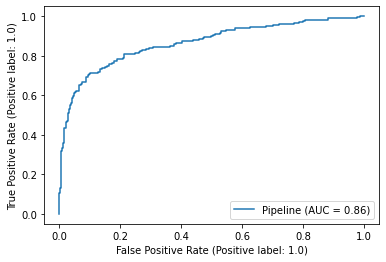

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline, Pipeline
from catboost import Pool, CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold
kfold=KFold(n_splits=5,random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.2,
                                                    stratify=y1,
                                                    random_state=11)
classifier = AdaBoostClassifier(random_state=1)
sampler = SMOTE(random_state=0)


rs_parameters =  {'adaboostclassifier__n_estimators': [10,50,250,1000],               
                  'adaboostclassifier__learning_rate': [0.01,0.1],
                  'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')
              }


smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kfold,
                         scoring='f1',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train,y_train)
bestimator = grid_imba.best_estimator_

# training set performance
print('training set performance')
y_pred1 = bestimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred1))
skplt.metrics.plot_confusion_matrix(y_test, y_pred1)
metrics.plot_roc_curve(bestimator,X_test, y_test)
plt.show()

# testing set performance
print('testing set performance')
y_pred = bestimator.predict(X1_t)
print(metrics.classification_report(y1_t, y_pred))
skplt.metrics.plot_confusion_matrix(y1_t, y_pred)
metrics.plot_roc_curve(bestimator ,X1_t, y1_t)
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
training set performance
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       928
         1.0       0.63      0.73      0.68       135

    accuracy                           0.91      1063
   macro avg       0.80      0.84      0.81      1063
weighted avg       0.92      0.91      0.92      1063



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


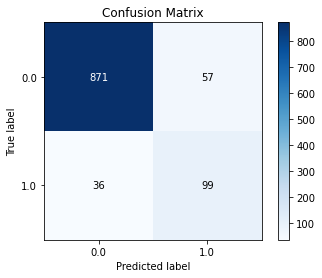

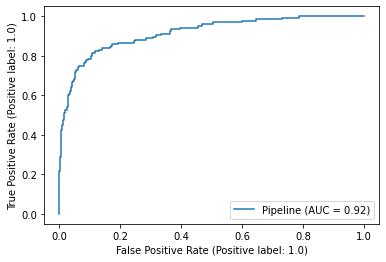

testing set performance
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1001
         1.0       0.65      0.65      0.65       182

    accuracy                           0.89      1183
   macro avg       0.79      0.79      0.79      1183
weighted avg       0.89      0.89      0.89      1183



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


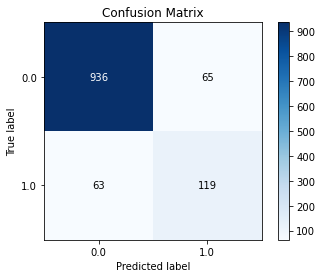

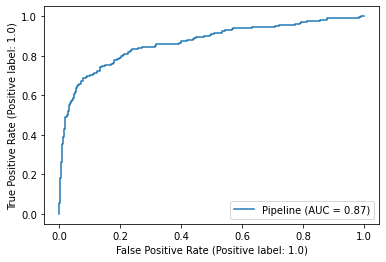

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline, Pipeline
from catboost import Pool, CatBoostClassifier
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold
kfold=KFold(n_splits=5,random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.2,
                                                    stratify=y1,
                                                    random_state=11)
classifier = AdaBoostClassifier(random_state=1)
sampler = BorderlineSMOTE(random_state=42, kind='borderline-1')
# 仅使用边界上的少数类样本来合成新样本，从而改善样本的类别分布
# Borderline-SMOTE1在对Danger点生成新样本时，在K近邻随机选择少数类样本（与SMOTE相同）
# 我做出來比Borderline-SMOTE2好(在k近邻中的任意一个样本(不关注样本类别)

rs_parameters =  {'adaboostclassifier__n_estimators': [10,50,250,1000],               
                  'adaboostclassifier__learning_rate': [0.01,0.1],
                  'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')
              }


smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kfold,
                         scoring='f1',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train,y_train)
bestimator = grid_imba.best_estimator_

# training set performance
print('training set performance')
y_pred1 = bestimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred1))
skplt.metrics.plot_confusion_matrix(y_test, y_pred1)
metrics.plot_roc_curve(bestimator,X_test, y_test)
plt.show()

# testing set performance
print('testing set performance')
y_pred = bestimator.predict(X1_t)
print(metrics.classification_report(y1_t, y_pred))
skplt.metrics.plot_confusion_matrix(y1_t, y_pred)
metrics.plot_roc_curve(bestimator ,X1_t, y1_t)
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
training set performance
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       928
         1.0       0.61      0.73      0.67       135

    accuracy                           0.91      1063
   macro avg       0.79      0.83      0.81      1063
weighted avg       0.92      0.91      0.91      1063



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


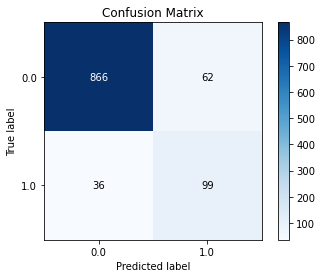

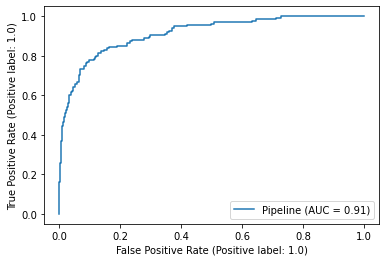

testing set performance
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1001
         1.0       0.65      0.64      0.64       182

    accuracy                           0.89      1183
   macro avg       0.79      0.79      0.79      1183
weighted avg       0.89      0.89      0.89      1183



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


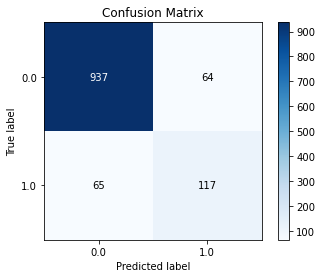

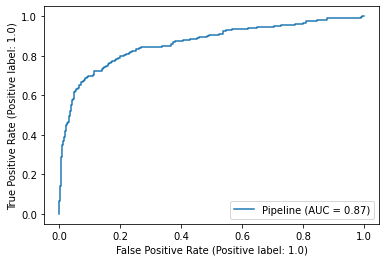

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline, Pipeline
from catboost import Pool, CatBoostClassifier
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold
kfold=KFold(n_splits=5,random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.2,
                                                    stratify=y1,
                                                    random_state=11)
classifier = AdaBoostClassifier(random_state=1)
# （adaptive synthetic sampling）
# 自适应合成抽样，与Borderline SMOTE相似，对不同的少数类样本赋予不同的权重，从而生成不同数量的样本。
sampler = ADASYN(random_state=42)


rs_parameters =  {'adaboostclassifier__n_estimators': [10,50,250,1000],               
                  'adaboostclassifier__learning_rate': [0.01,0.1],
                  'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')
              }


smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kfold,
                         scoring='f1',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train,y_train)
bestimator = grid_imba.best_estimator_

# training set performance
print('training set performance')
y_pred1 = bestimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred1))
skplt.metrics.plot_confusion_matrix(y_test, y_pred1)
metrics.plot_roc_curve(bestimator,X_test, y_test)
plt.show()

# testing set performance
print('testing set performance')
y_pred = bestimator.predict(X1_t)
print(metrics.classification_report(y1_t, y_pred))
skplt.metrics.plot_confusion_matrix(y1_t, y_pred)
metrics.plot_roc_curve(bestimator ,X1_t, y1_t)
plt.show()

#### 2.AdaBoost + UnderSampling

Fitting 5 folds for each of 16 candidates, totalling 80 fits
training set performance
              precision    recall  f1-score   support

         0.0       0.97      0.83      0.90       928
         1.0       0.42      0.84      0.56       135

    accuracy                           0.83      1063
   macro avg       0.70      0.83      0.73      1063
weighted avg       0.90      0.83      0.85      1063



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


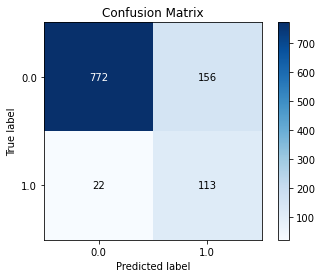

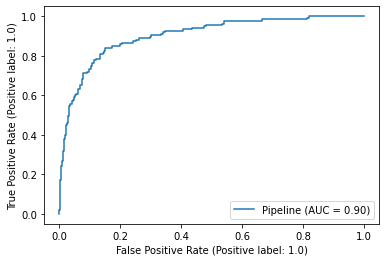

testing set performance
              precision    recall  f1-score   support

         0.0       0.95      0.81      0.87      1001
         1.0       0.42      0.75      0.53       182

    accuracy                           0.80      1183
   macro avg       0.68      0.78      0.70      1183
weighted avg       0.86      0.80      0.82      1183



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


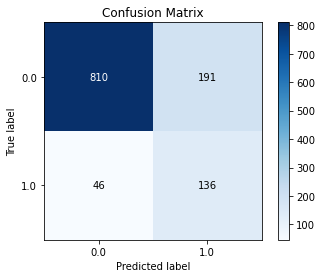

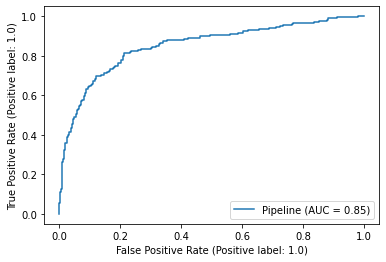

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline, Pipeline
from catboost import Pool, CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold
kfold=KFold(n_splits=5,random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.2,
                                                    stratify=y1,
                                                    random_state=11)
classifier = AdaBoostClassifier(random_state=1)
sampler = under_sampling.RandomUnderSampler(sampling_strategy=1.0,random_state=0)

rs_parameters =  {'adaboostclassifier__n_estimators': [10,50,250,1000],               
                  'adaboostclassifier__learning_rate': [0.01,0.1],
                  'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')
              }


smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kfold,
                         scoring='f1',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train,y_train)
bestimator = grid_imba.best_estimator_

# training set performance
print('training set performance')
y_pred1 = bestimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred1))
skplt.metrics.plot_confusion_matrix(y_test, y_pred1)
metrics.plot_roc_curve(bestimator,X_test, y_test)
plt.show()

# testing set performance
print('testing set performance')
y_pred = bestimator.predict(X1_t)
print(metrics.classification_report(y1_t, y_pred))
skplt.metrics.plot_confusion_matrix(y1_t, y_pred)
metrics.plot_roc_curve(bestimator ,X1_t, y1_t)
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
training set performance
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95       928
         1.0       0.77      0.50      0.61       135

    accuracy                           0.92      1063
   macro avg       0.85      0.74      0.78      1063
weighted avg       0.91      0.92      0.91      1063



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


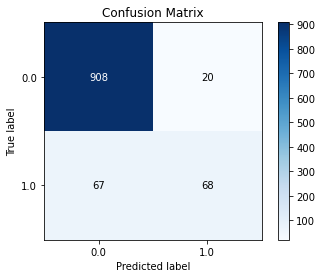

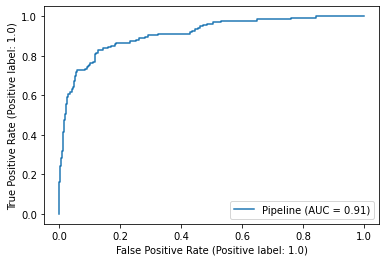

testing set performance
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      1001
         1.0       0.77      0.45      0.57       182

    accuracy                           0.89      1183
   macro avg       0.84      0.71      0.75      1183
weighted avg       0.89      0.89      0.88      1183



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


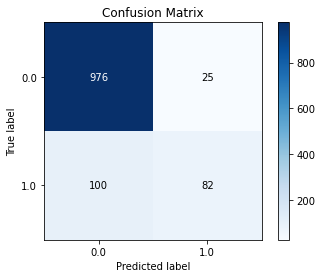

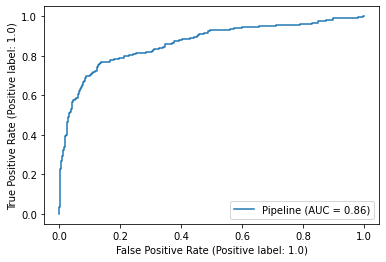

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline, Pipeline
from catboost import Pool, CatBoostClassifier
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold
kfold=KFold(n_splits=5,random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.2,
                                                    stratify=y1,
                                                    random_state=11)
classifier = AdaBoostClassifier(random_state=1)
sampler = TomekLinks()


rs_parameters =  {'adaboostclassifier__n_estimators': [10,50,250,1000],               
                  'adaboostclassifier__learning_rate': [0.01,0.1],
                  'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')
              }


smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kfold,
                         scoring='f1',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train,y_train)
bestimator = grid_imba.best_estimator_

# training set performance
print('training set performance')
y_pred1 = bestimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred1))
skplt.metrics.plot_confusion_matrix(y_test, y_pred1)
metrics.plot_roc_curve(bestimator,X_test, y_test)
plt.show()

# testing set performance
print('testing set performance')
y_pred = bestimator.predict(X1_t)
print(metrics.classification_report(y1_t, y_pred))
skplt.metrics.plot_confusion_matrix(y1_t, y_pred)
metrics.plot_roc_curve(bestimator ,X1_t, y1_t)
plt.show()

中間我試過NearMiss(超級爛 直接放棄)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
training set performance
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       928
         1.0       0.71      0.62      0.66       135

    accuracy                           0.92      1063
   macro avg       0.83      0.79      0.81      1063
weighted avg       0.92      0.92      0.92      1063



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


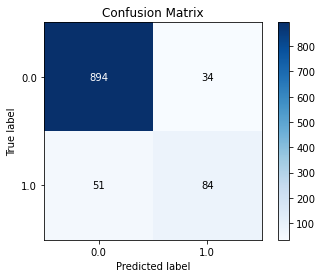

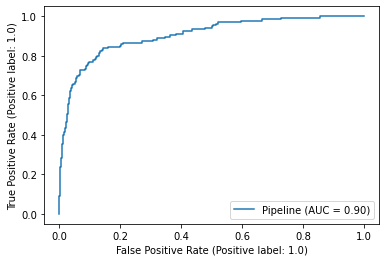

testing set performance
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      1001
         1.0       0.66      0.57      0.61       182

    accuracy                           0.89      1183
   macro avg       0.79      0.76      0.77      1183
weighted avg       0.88      0.89      0.89      1183



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


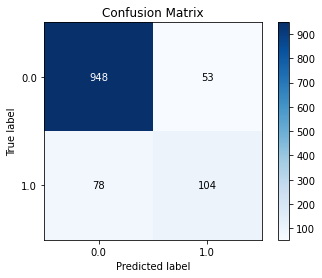

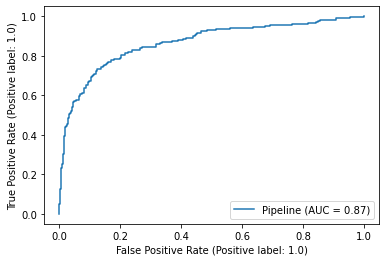

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline, Pipeline
from catboost import Pool, CatBoostClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold
kfold=KFold(n_splits=5,random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.2,
                                                    stratify=y1,
                                                    random_state=11)
classifier = AdaBoostClassifier(random_state=1)
# define the undersampling method
sampler = EditedNearestNeighbours(n_neighbors=3)


rs_parameters =  {'adaboostclassifier__n_estimators': [10,50,250,1000],               
                  'adaboostclassifier__learning_rate': [0.01,0.1],
                  'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')
              }


smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kfold,
                         scoring='f1',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train,y_train)
bestimator = grid_imba.best_estimator_

# training set performance
print('training set performance')
y_pred1 = bestimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred1))
skplt.metrics.plot_confusion_matrix(y_test, y_pred1)
metrics.plot_roc_curve(bestimator,X_test, y_test)
plt.show()

# testing set performance
print('testing set performance')
y_pred = bestimator.predict(X1_t)
print(metrics.classification_report(y1_t, y_pred))
skplt.metrics.plot_confusion_matrix(y1_t, y_pred)
metrics.plot_roc_curve(bestimator ,X1_t, y1_t)
plt.show()

#### 3.AdaBoost+ Over + Undersampling

Fitting 5 folds for each of 16 candidates, totalling 80 fits
training set performance
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       928
         1.0       0.66      0.74      0.70       135

    accuracy                           0.92      1063
   macro avg       0.81      0.84      0.83      1063
weighted avg       0.92      0.92      0.92      1063



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


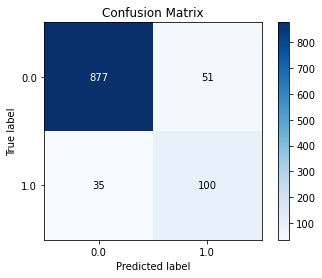

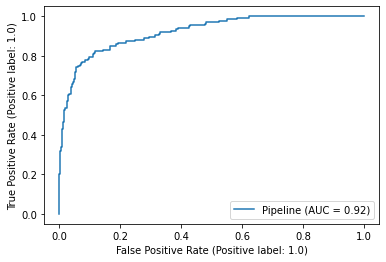

testing set performance
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      1001
         1.0       0.65      0.64      0.64       182

    accuracy                           0.89      1183
   macro avg       0.79      0.79      0.79      1183
weighted avg       0.89      0.89      0.89      1183



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


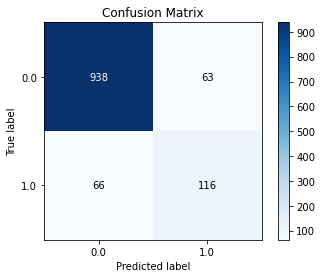

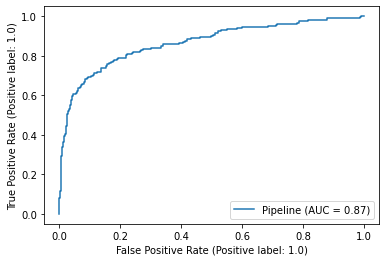

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import AdaBoostClassifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold
kfold=KFold(n_splits=5,random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.2,
                                                    stratify=y1,
                                                    random_state=11)
classifier = AdaBoostClassifier(random_state=1)

smote = SMOTE(random_state=1)
enn = EditedNearestNeighbours()
sampler = SMOTEENN(smote=smote, enn=enn, random_state=1)


rs_parameters =  {'adaboostclassifier__n_estimators': [10,50,250,1000],               
                  'adaboostclassifier__learning_rate': [0.01,0.1],
                  'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')
              }


smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kfold,
                         scoring='f1',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train,y_train)
bestimator = grid_imba.best_estimator_

# training set performance
print('training set performance')
y_pred1 = bestimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred1))
skplt.metrics.plot_confusion_matrix(y_test, y_pred1)
metrics.plot_roc_curve(bestimator,X_test, y_test)
plt.show()

# testing set performance
print('testing set performance')
y_pred = bestimator.predict(X1_t)
print(metrics.classification_report(y1_t, y_pred))
skplt.metrics.plot_confusion_matrix(y1_t, y_pred)
metrics.plot_roc_curve(bestimator ,X1_t, y1_t)
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
training set performance
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       928
         1.0       0.63      0.73      0.68       135

    accuracy                           0.91      1063
   macro avg       0.80      0.83      0.81      1063
weighted avg       0.92      0.91      0.91      1063



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


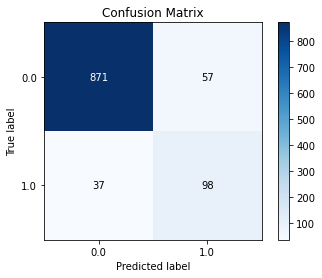

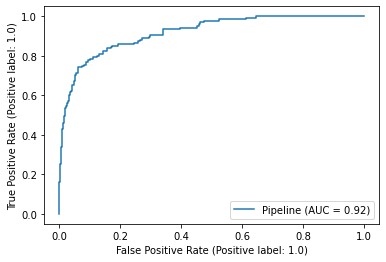

testing set performance
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      1001
         1.0       0.64      0.63      0.64       182

    accuracy                           0.89      1183
   macro avg       0.79      0.78      0.79      1183
weighted avg       0.89      0.89      0.89      1183



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


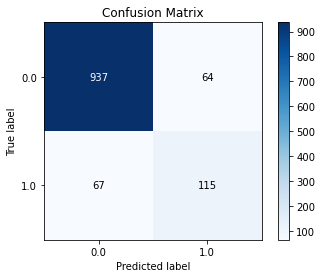

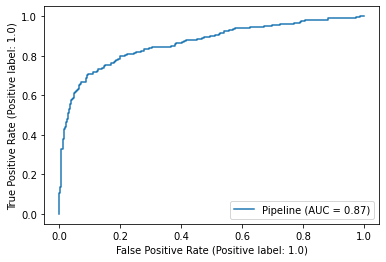

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import AdaBoostClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,KFold
kfold=KFold(n_splits=5,random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y1,
                                                    test_size=0.2,
                                                    stratify=y1,
                                                    random_state=11)
classifier = AdaBoostClassifier(random_state=1)

sampler = SMOTETomek(random_state=0)


rs_parameters =  {'adaboostclassifier__n_estimators': [10,50,250,1000],               
                  'adaboostclassifier__learning_rate': [0.01,0.1],
                  'adaboostclassifier__algorithm': ('SAMME', 'SAMME.R')
              }


smp_pipeline = make_pipeline(sampler, classifier)
grid_imba = GridSearchCV(smp_pipeline,
                         param_grid=rs_parameters,
                         cv=kfold,
                         scoring='f1',
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=True
                        )
grid_imba.fit(X_train,y_train)
bestimator = grid_imba.best_estimator_

# training set performance
print('training set performance')
y_pred1 = bestimator.predict(X_test)
print(metrics.classification_report(y_test, y_pred1))
skplt.metrics.plot_confusion_matrix(y_test, y_pred1)
metrics.plot_roc_curve(bestimator,X_test, y_test)
plt.show()

# testing set performance
print('testing set performance')
y_pred = bestimator.predict(X1_t)
print(metrics.classification_report(y1_t, y_pred))
skplt.metrics.plot_confusion_matrix(y1_t, y_pred)
metrics.plot_roc_curve(bestimator ,X1_t, y1_t)
plt.show()

其他可以嘗試看看的組合
RENN + SMOTE, RUS + ROS,
RENN + RUS, and RUS + SMOTE. 